This is for the final project


In [1]:
import pandas as pd
import numpy as np

import requests
from urllib.request import urlopen

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors 
import folium

import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim

from sklearn.cluster import KMeans

## 1.Preparing the Data

### Getting the neighborhood names:

In [2]:
from bs4 import BeautifulSoup
html=urlopen('https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Los_Angeles')
soup=BeautifulSoup(html,'html.parser')

neighborhood=[]
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhood.append(row.text.split('\u200e')[0].strip(','))
    neighborhood[-1]=' '.join(neighborhood[-1].split()[1:])

In [3]:
la=pd.DataFrame({'Neighborhood':neighborhood[3:]})
la['Neighborhood']=la['Neighborhood'].replace("Exposition Park (Los Angeles neighborhood)", 'Exposition Park')

### Getting the geographic positions

In [4]:
column_name=['Neighborhood','Latitude','Longitude']

locations = pd.DataFrame(columns=column_name)

In [5]:
name=la['Neighborhood']
latitude=None
longitude=None
location=None

for item in range(0,len(name)):
    hood=name[item]
    geolocator=Nominatim(user_agent='ny_explorer')
    loc=geolocator.geocode(hood)
    try:
        lat=loc.latitude
        lon=loc.longitude
        #print(hood, lat,lon)
        locations=locations.append({'Neighborhood':hood,'Latitude':lat,'Longitude': lon},
                            ignore_index=True)
    except:
        locations=locations.append({'Neighborhood':hood,'Latitude':'None','Longitude': 'None'},
                            ignore_index=True)

In [ ]:
locations.drop_duplicates(subset=['Latitude','Longitude'],inplace=True)
la_data=pd.merge(la,locations,how='left',on='Neighborhood')
la_data=la_data[la_data['Latitude']!='None'].dropna(axis=0)
la_data=pd.DataFrame(la_data)
la_data.to_csv('la_locations.csv')

## 2. Exploring the Neighborhood

#### Exploring the district Venues with Foursquare

In [6]:
la_data=pd.read_csv('la_locations.csv',index_col=0)
la_data.head()

,Neighborhood,Latitude,Longitude
0,Central Los Angeles,34.053691,-118.242767
1,Eastside Los Angeles,34.030625,-118.246639
3,Northwest Los Angeles,-11.275489,-67.382600
4,San Fernando Valley,34.214885,-118.499820
5,South Los Angeles,33.928291,-118.278813


In [7]:
CLIENT_ID = 'Y40FH1X1BXZ0NI12IU0ZDV0Y3SZI5WAEAP2PQJBVKDIPGNH3' # your Foursquare ID
CLIENT_SECRET = 'TDAE2HKVLAIU2B4H3QEOU5JBJAXRERU0TE5HAJMXLDIEJWGQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Y40FH1X1BXZ0NI12IU0ZDV0Y3SZI5WAEAP2PQJBVKDIPGNH3
CLIENT_SECRET:TDAE2HKVLAIU2B4H3QEOU5JBJAXRERU0TE5HAJMXLDIEJWGQ


#### Let's first look at the first neighborhood

In [8]:
first_lat=la_data.loc[0,'Latitude']
first_lon=la_data.loc[0,'Longitude']

In [9]:
LIMIT=100 
radius=500
url='http://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET,VERSION,first_lat,first_lon,radius, LIMIT)

getting the json file of venues 

In [10]:
result=requests.get(url).json()

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
venues=result['response']['groups'][0]['items']
venues=json_normalize(venues)

columns=['venue.name','venue.categories','venue.location.lat','venue.location.lng']
venues=venues.loc[:,columns]

#get the category for each row
venues['venue.categories']=venues.apply(get_category_type, axis=1)

venues.columns=[col.split(".")[-1] for col in venues.columns]
print('There are {} unique categories in neighborhood {}.'.format(len(venues['categories'].unique()),la_data.iloc[0,0]))

There are 25 unique categories in neighborhood Central Los Angeles.


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


we can see that only the first neighborhood in the tabel has 25 unique venues categories, but our interest is to explore what type of constructions are near each neighborhood, and clearly too detailed category is not good for a general analysis, so we only explore the widest category-defination by Foursquares:

In [24]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(categories_url).json()

In [25]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(results['response']['categories'], 0, 0)
categories_list[0][1]

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


'4d4b7104d754a06370d81259'

In [26]:
def get_venues_count(lat,long, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                long,
                radius,
                categoryId)
    return requests.get(explore_url).json()['response']['totalResults']

In [27]:
la_venues = la_data.copy()
for c in categories_list:
    la_venues[c[0]] = 0
    
la_venues.head()

,Neighborhood,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Central Los Angeles,34.053691,-118.242767,0,0,0,0,0,0,0,0,0,0
1,Eastside Los Angeles,34.030625,-118.246639,0,0,0,0,0,0,0,0,0,0
3,Northwest Los Angeles,-11.275489,-67.382600,0,0,0,0,0,0,0,0,0,0
4,San Fernando Valley,34.214885,-118.499820,0,0,0,0,0,0,0,0,0,0
5,South Los Angeles,33.928291,-118.278813,0,0,0,0,0,0,0,0,0,0


In [30]:
explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                first_lat,
                first_lon,
                1000,
                categories_list[0][1])
requests.get(explore_url).json()

{'meta': {'code': 200, 'requestId': '5f4d773e3a36067f056f4f57'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Civic Center',
  'headerFullLocation': 'Civic Center, Los Angeles',
  'headerLocationGranularity': 'neighborhood',
  'query': 'arts entertainment',
  'totalResults': 73,
  'suggestedBounds': {'ne': {'lat': 34.06269090900001,
    'lng': -118.2319240389281},
   'sw': {'lat': 34.04469089099999, 'lng': -118.25360916107189}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b611730f964a52050092ae3',
       'name': 'Blue Whale Bar',
       'location': {'address': '123 Astronaut',
        'crossStreet': 'btwn 1st & 2nd',
        'lat': 34.04988397300476,
        'lng': -118.242

In [32]:
for i, row in la_venues.iterrows():
    for c in categories_list:        
        la_venues.loc[i, c[0]] = get_venues_count(la_venues.Latitude.iloc[i], la_venues.Longitude.iloc[i], radius=1000, categoryId=c[1])
    #print(i)
    #df_venues.to_csv('area_venues.csv')

KeyError: 'totalResults'

In [33]:
la_venues.head()

,Neighborhood,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Central Los Angeles,34.053691,-118.242767,73,8,2,171,63,98,141,30,144,107
1,Eastside Los Angeles,34.030625,-118.246639,10,1,2,56,4,7,77,1,128,6
3,Northwest Los Angeles,-11.275489,-67.382600,5,3,0,16,7,7,35,0,47,10
4,San Fernando Valley,34.214885,-118.499820,2,2,0,8,1,5,11,0,19,4
5,South Los Angeles,33.928291,-118.278813,3,63,1,47,5,48,100,17,69,7


In [35]:
la_venues.to_csv('la_venues.csv')

Now to let the cluster works better, we need to **normalize** the data

And as we are interested in how each category distributed in different neighborhood, we use a plot to show the results:

In [41]:
from sklearn.preprocessing import MinMaxScaler

X = la_venues.values[:,3:]
scaled = MinMaxScaler().fit_transform(X)
scaled=pd.DataFrame(scaled,columns=la_venues.columns[3:])
scaled.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,1.000000,0.079208,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.791209,1.000000
1,0.136986,0.009901,1.0,0.327485,0.063492,0.071429,0.546099,0.033333,0.703297,0.056075
2,0.068493,0.029703,0.0,0.093567,0.111111,0.071429,0.248227,0.000000,0.258242,0.093458
3,0.027397,0.019802,0.0,0.046784,0.015873,0.051020,0.078014,0.000000,0.104396,0.037383
4,0.041096,0.623762,0.5,0.274854,0.079365,0.489796,0.709220,0.566667,0.379121,0.065421


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

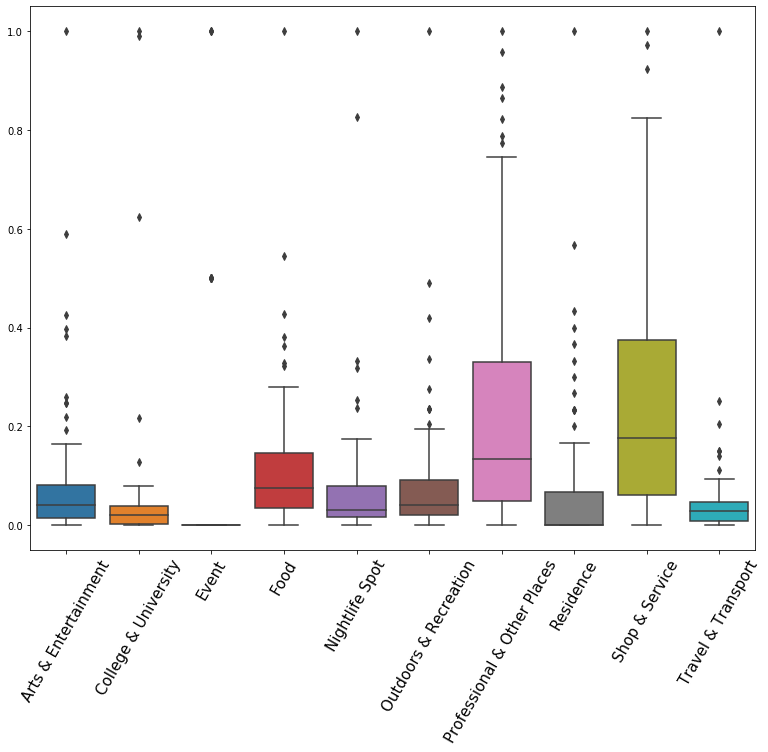

In [42]:
fig=plt.figure(figsize=(13,10))
ax=sns.boxplot(data=scaled)
plt.xticks(rotation=60, ha='center',fontsize=15)

As there is little informationa about 'Event' and 'Residence', I'll leave them not to be diagnozied here and only focus on the remaining 8 categories:

## 3. Clustering District

#### Using the elbow method to choose the 'optimal' K

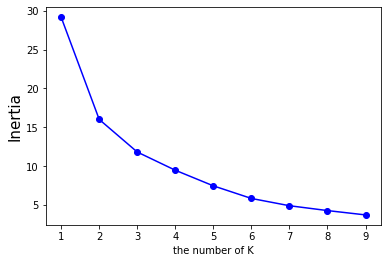

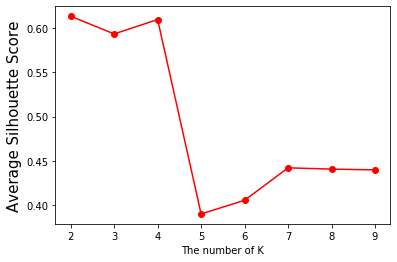

In [44]:
#elbow method
k_list=range(1,10)
inertia=[KMeans(n_clusters=k, random_state=0).fit(scaled).inertia_ for k in k_list]

plt.figure(1)
plt.plot(k_list, inertia,'-bo')
plt.xlabel('the number of K')
plt.ylabel('Inertia',fontsize=15)

#average silhouette score method:
from sklearn.metrics import silhouette_score
ks=range(2,10)
scores=[]
for k in ks:
    cluster=KMeans(k,random_state=0)
    labels=cluster.fit_predict(scaled)
    score=silhouette_score(scaled, labels)
    scores.append(score)
    

#plot the score functions
plt.figure(2)
plt.plot(ks, scores,'-bo',color='red')
plt.xlabel('The number of K')
plt.ylabel('Average Silhouette Score',fontsize=15)

plt.show()

In [45]:
k=4
kmeans=KMeans(n_clusters=k, random_state=0).fit(scaled)

print('There are {} unique labels assigned to each neighborhood'.format(len(set(kmeans.labels_))))
kmeans.labels_[0:10]
set(kmeans.labels_)

There are 4 unique labels assigned to each neighborhood


{0, 1, 2, 3}

In [46]:
#first, add the cluster labels to the neighborhood lists
la_venues.insert(0,'Cluster Labels', kmeans.labels_)
la_venues.head()

,Cluster Labels,Neighborhood,Latitude,Longitude,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,3,Central Los Angeles,34.053691,-118.242767,73,8,2,171,63,98,141,30,144,107
1,1,Eastside Los Angeles,34.030625,-118.246639,10,1,2,56,4,7,77,1,128,6
3,0,Northwest Los Angeles,-11.275489,-67.382600,5,3,0,16,7,7,35,0,47,10
4,0,San Fernando Valley,34.214885,-118.499820,2,2,0,8,1,5,11,0,19,4
5,2,South Los Angeles,33.928291,-118.278813,3,63,1,47,5,48,100,17,69,7


In [47]:
cluster_map=folium.Map(location=[first_lat,first_lon], zoom_start=10) #the coordinates for Toronto, Ontario

#set the color scheme
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys))) 
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors=[]
for lat, lon, hood, cluster in zip(la_venues['Latitude'],la_venues['Longitude'],la_venues['Neighborhood'],la_venues['Cluster Labels']):
    label=folium.Popup(str(hood)+'Cluster '+str(cluster), parse_html=True)
    folium.CircleMarker([lat,lon],
                       radius=5,
                       popup=label,
                       color=rainbow[int(cluster-1)],
                       fill=True,
                       fill_color=rainbow[int(cluster-1)],
                       fill_opacity=0.6).add_to(cluster_map)
cluster_map

## 4. Finally, we can examine Clusters

we can examine each cluster and determine the discriminating venues categories that distinguish each cluster.

Firstly, to better visualize the destribution of different venues for each cluster group, define a function `get_destribution()`:

In [48]:
scaled.insert(0,'Cluster Labels', kmeans.labels_)
scaled.head()

,Cluster Labels,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,3,1.000000,0.079208,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.791209,1.000000
1,1,0.136986,0.009901,1.0,0.327485,0.063492,0.071429,0.546099,0.033333,0.703297,0.056075
2,0,0.068493,0.029703,0.0,0.093567,0.111111,0.071429,0.248227,0.000000,0.258242,0.093458
3,0,0.027397,0.019802,0.0,0.046784,0.015873,0.051020,0.078014,0.000000,0.104396,0.037383
4,2,0.041096,0.623762,0.5,0.274854,0.079365,0.489796,0.709220,0.566667,0.379121,0.065421


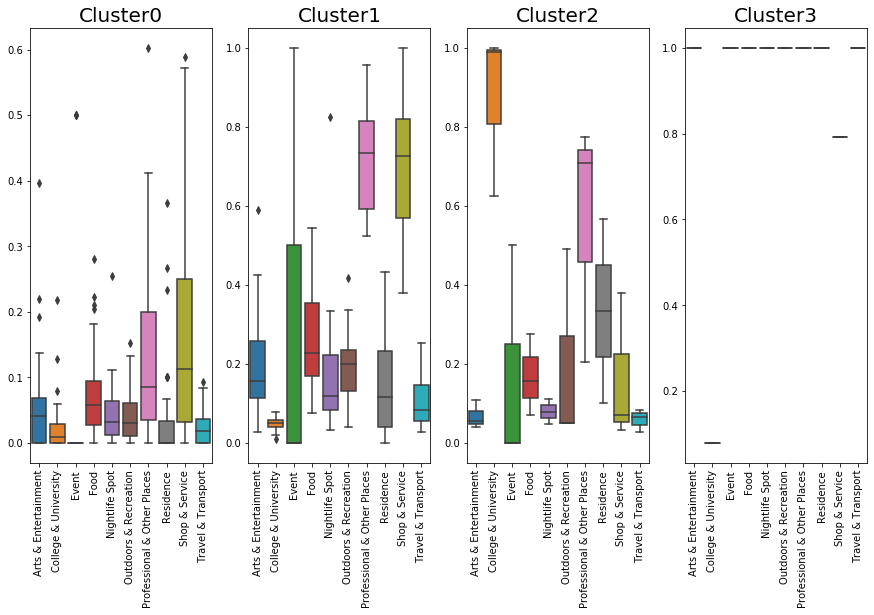

In [49]:
fig,axes=plt.subplots(1,4,figsize=(15,8))
for i in range(0,4):
    axes[i]=sns.boxplot(data=scaled[scaled['Cluster Labels']==i].drop('Cluster Labels',axis=1),ax=axes[i])
    axes[i].set_xticklabels(labels=scaled.columns[1:],rotation=90)
    axes[i].set_title('Cluster' + str(i), fontsize=20)
    #plt.xticks(rotation=90)

    

So from the visualization, we can see that different cluster do have some distinctive categories from the others, but as the neighbornoods clusted as '3', there are little universities, the rest are distributed mostly equally.

## 5. Discussion 

'Academic astomosphere' is an important element to segment different neighborhoods, if people are looking forward to live near the univeristy and college, he or she should move to those labeled cluster'2';

If people are working for placed to develop career and related to more preofessional events/services, areas labeled 1 can be the first choice.

Neighorboods labels in 0 can be seen relatively underdeveled, with lower frequency of all categories.